# Create new utility function

Import data.

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

Create inputs to the DrugEnv.

In [3]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner, Generator
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.utility import ClassicUtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    Generator(building_blocks, fingerprints)
)

# create evaluators
log_P_utility = ClassicUtilityFunction(
    RDKitOracle('MolLogP'),
    ideal=(1, 4),
    acceptable=(0, 5)
)

log_S_utility = ClassicUtilityFunction(
    DGLOracle('GCN_canonical_ESOL'),
    ideal=(-2, 0),
    acceptable=(-4, 0.5)
)

weight_utility = ClassicUtilityFunction(
    RDKitOracle('HeavyAtomMolWt'),
    ideal=(400, 500),
    acceptable=(300, 600)
)

# create utility function
def composite_utility_function(molecules):
    return log_P_utility(molecules) * log_S_utility(molecules)

First, set up the environment.

In [20]:
from tqdm.notebook import tqdm

class Experiment:
    
    def __init__(self, drug_agent, drug_env):
        self.drug_agent = drug_agent
        self.drug_env = drug_env
    
    def run(self, num_trials, progress=False):
        
        results = []
        for trial in tqdm(range(num_trials)):

            observations, info = drug_env.reset()

            if progress:
                pbar = tqdm(total = drug_env.budget)
            
            while True:
                action = drug_agent.act(observations)
                observations, _, terminated, truncated, _ = drug_env.step(action)
                
                if progress:
                    pbar.n = len(drug_env.library.annotated)
                    pbar.update()
                
                if terminated or truncated:
                    break

            result = {
                'trial': trial,
                **vars(drug_agent)
            }

            if terminated:
                cost = len(drug_env.library.annotated)
                result.update({'cost': cost, 'outcome': 1})

            if truncated:
                result.update({'outcome': 0})

            results.append(result)

        return results

In [146]:
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent

drug_env = DrugEnv(
    library_designer,
    library = deck[[300]].update_annotations(),
    assays = [log_P_utility.oracle, log_S_utility.oracle],
    budget = 100,
    utility_function = composite_utility_function,
)

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 10}},
    {'name': 'MolLogP'},
    {'name': 'GCN_canonical_ESOL'},
]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    utility_function = composite_utility_function,
    epsilon = 0.0,
    branch_factor = 5
)

experiment = Experiment(drug_agent, drug_env)
result = experiment.run(1, progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

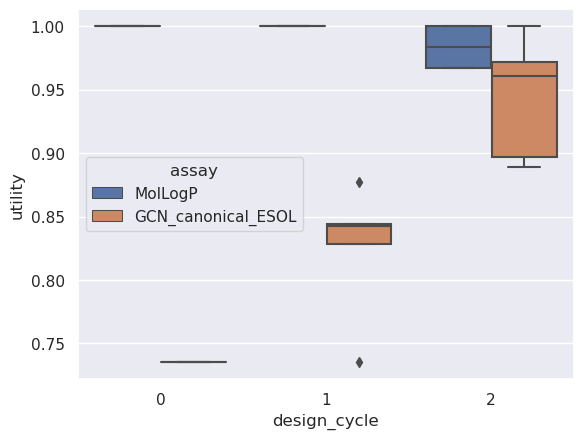

In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

records = []
for utility_fn in [log_P_utility, log_S_utility]:
    scores = utility_fn(drug_env.library.annotated)
    for molecule, score in zip(drug_env.library.annotated, scores):
        records.append(
            {
                'design_cycle': molecule.design_cycle,
                'utility': score,
                'assay': utility_fn.oracle.name
            }
        )
        
sns.boxplot(
    pd.DataFrame(records),
    x='design_cycle',
    y='utility',
    hue='assay',
)

plt.show()

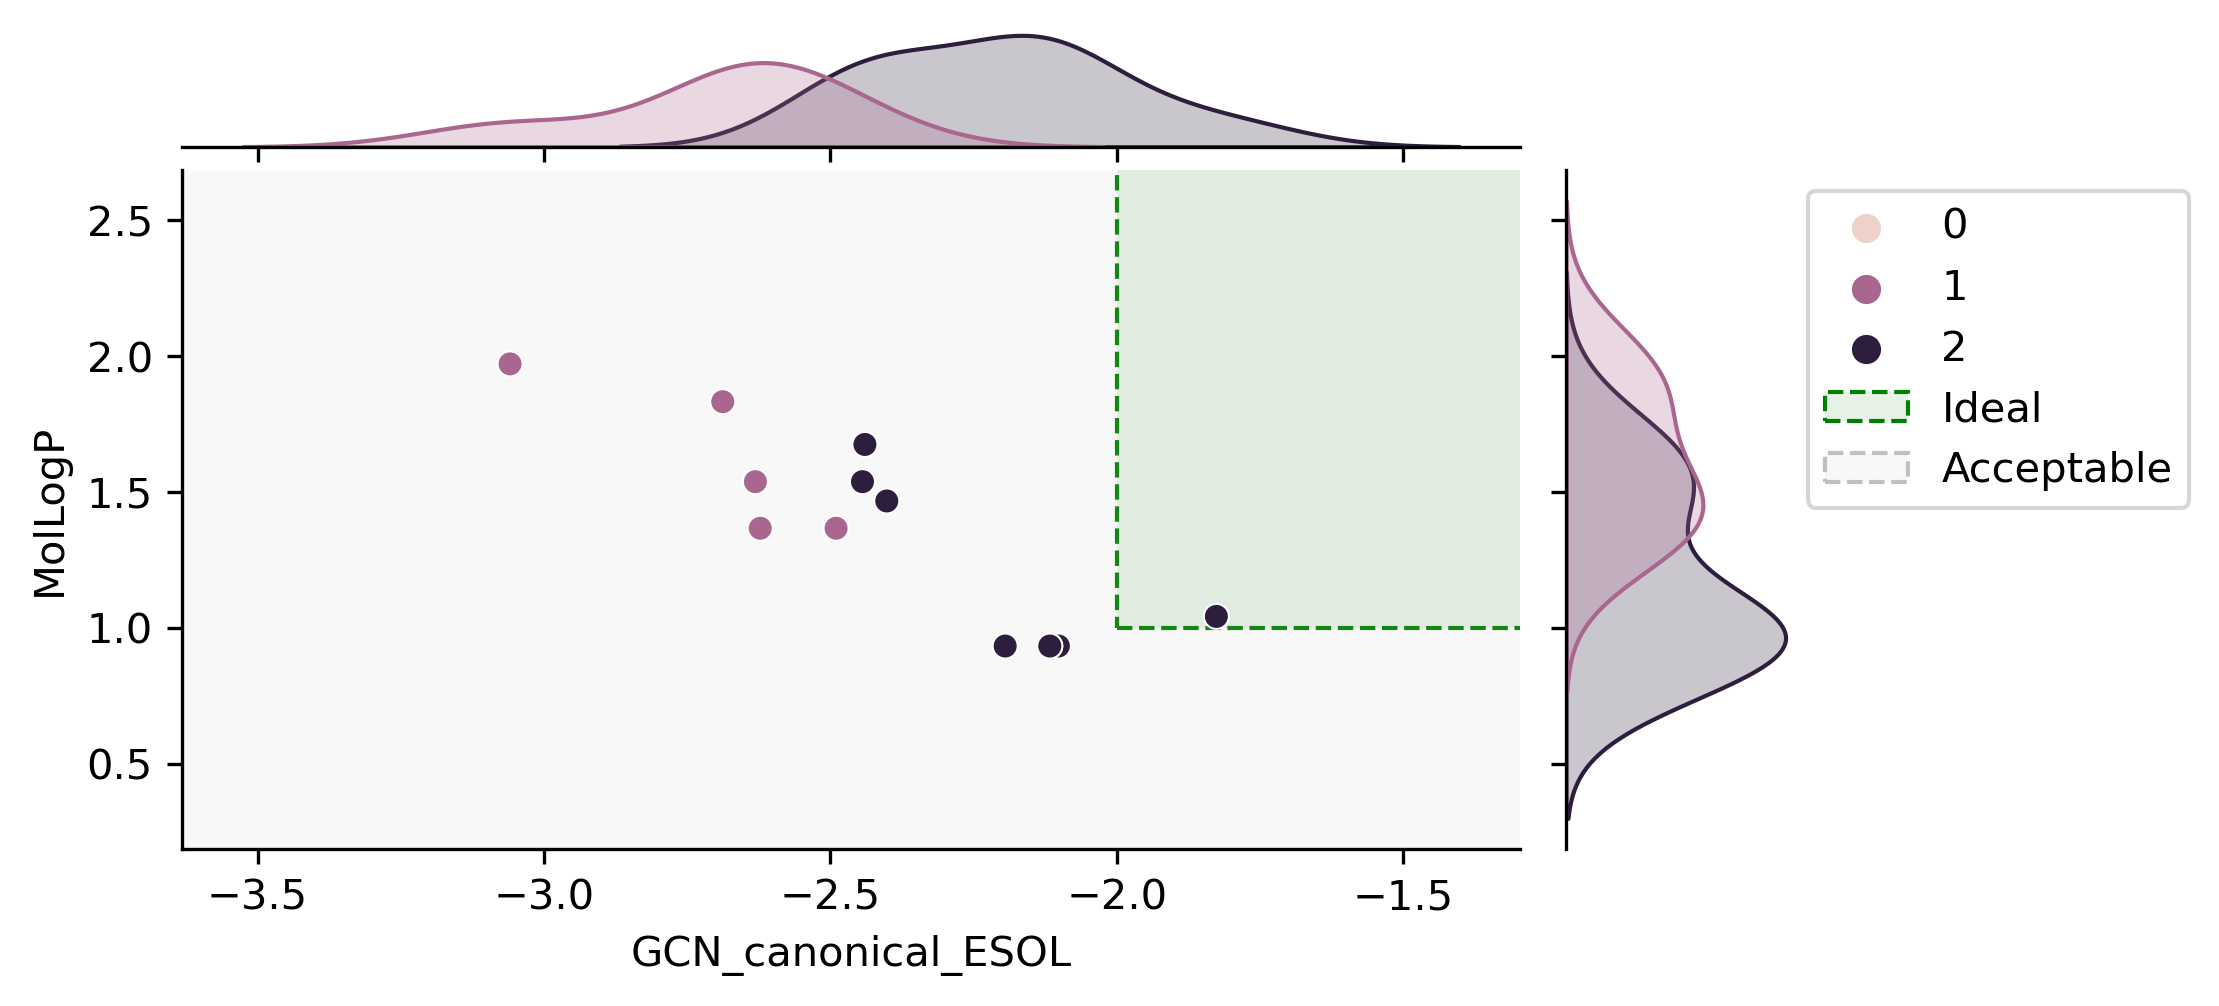

In [148]:
sns.reset_orig()
dg.plotting.plot(drug_env.library.annotated, [log_S_utility, log_P_utility])
plt.show()

Experimenting with Agent hyperparameters.

In [137]:
results = []
noises = [0.0, 1e-2, 1e-1, 2e-1, 4e-1]
# noises = np.linspace(0, 1, 50)

for noise in tqdm(noises):

    drug_env = DrugEnv(
        library_designer,
        library = deck[[300]].update_annotations(),
        assays = [log_P_utility.oracle, log_S_utility.oracle],
        budget = 1_000,
        utility_function = composite_utility_function,
    )

    drug_agent = NoisySequentialDrugAgent(
        noise = noise,
        sequence = sequence,
        utility_function = composite_utility_function,
        epsilon = 0.0,
        branch_factor = 5
    )

    experiment = Experiment(drug_agent, drug_env)
    result = experiment.run(25)
    results.extend(result)
    
df = pd.DataFrame(results)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [138]:
import pandas as pd

def ecdf(costs):
    costs_sorted = np.sort(costs)
    probs = 1. * np.arange(1, len(costs) + 1) / len(costs)

    costs_sorted = [0.0, *costs_sorted]
    probs = [0.0, *probs]
    
    return costs_sorted, probs

data = pd.DataFrame()
for noise in noises:
    raw_costs = [r['cost'] for r in df.to_dict('records') if r['noise'] == noise]
    cost, prob = ecdf(raw_costs)
    temp = pd.DataFrame({'cost': cost, 'prob': prob, 'noise': noise})
    data = pd.concat([data, temp])

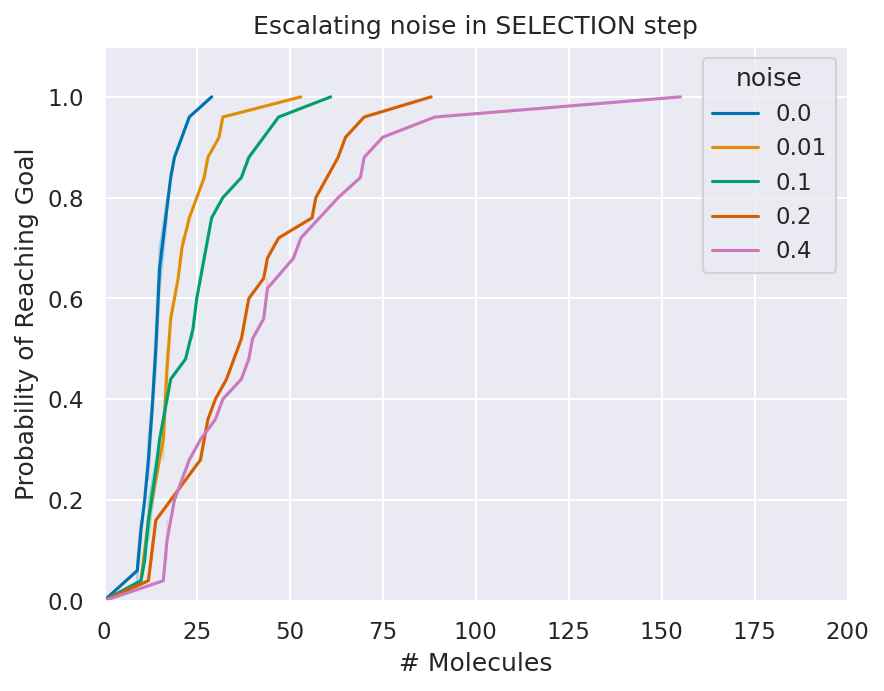

In [143]:
import matplotlib.pyplot as plt

sns.set()
g = sns.lineplot(
    data,
    x='cost',
    y='prob',
    hue='noise',
    palette='colorblind'
)

g.set_title('Escalating noise in SELECTION step')
g.set_xlabel('# Molecules')
g.set_ylabel('Probability of Reaching Goal')
g.set_ylim([0, 1.1])
g.set_xlim(0, 200)

plt.gcf().set_dpi(150)
plt.show()

Probability of success diagram.

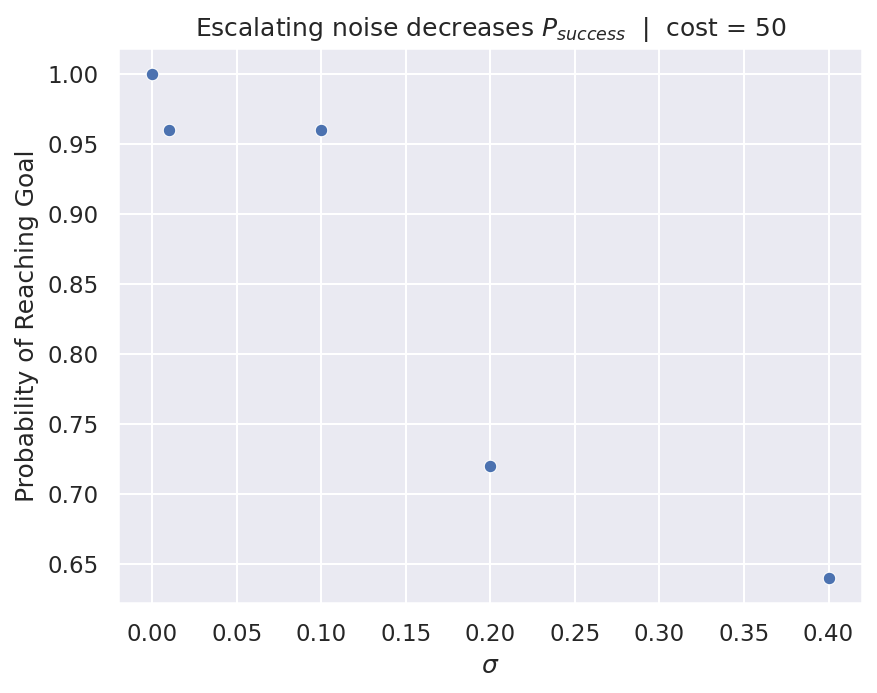

In [144]:
cost = 50
prob_success = lambda noise, cost: len(df.query(f'noise == {noise}').query(f'cost < {cost}')) / 25
probs = [prob_success(noise, cost) for noise in noises]

g = sns.scatterplot(y=probs, x=noises)

g.set_title('Escalating noise decreases $P_{success}$  |  cost = 50')
g.set_xlabel('$\\sigma$')
g.set_ylabel('Probability of Reaching Goal')
plt.gcf().set_dpi(150)

plt.show()